In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torch.autograd as autograd

import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import save_image

In [2]:
batch_size = 64
lr_d = 2e-4
lr_g = 1e-3
nz = 64
c_size = 10
ngf = 64
ndf = 64
epochs = 80
load_model = False
model_path = "./"
G_ = model_path + "G.pth"

In [3]:
def weight_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [4]:
def _noise_sample(dis_c, noise, bs):

    idx = np.random.randint(10, size=bs)
    c = np.zeros((bs, 10))
    c[range(bs),idx] = 1.0

    dis_c.data.copy_(torch.Tensor(c))
    noise.data.uniform_(-1.0, 1.0)
    z = torch.cat([noise, dis_c], 1).view(-1, 64, 1, 1)

    return z, idx

In [5]:
class _netG(nn.Module):
    def __init__(self, inplace):
        super(_netG, self).__init__()
        self.inplace = inplace
        
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, kernel_size=4, stride=1, bias=False),
            nn.BatchNorm2d(ngf*8, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=self.inplace),
            nn.ConvTranspose2d(ngf*8, ngf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*4, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=self.inplace),
            nn.ConvTranspose2d(ngf*4, ngf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf*2, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=self.inplace),
            nn.ConvTranspose2d(ngf*2, ngf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ngf, eps=1e-05, momentum=0.1, affine=True),
            nn.ReLU(inplace=self.inplace),
            nn.ConvTranspose2d(ngf, 1, kernel_size=4, stride=2, padding=1, bias=False),
            #nn.Tanh()
            nn.Sigmoid()
        )
    
    def forward(self, input):
        output = self.main(input)
        return output

In [6]:
class _netFE(nn.Module):
    ''' front end part of discriminator and Q'''

    def __init__(self, inplace):
        super(_netFE, self).__init__()
        self.inplace = inplace

        self.main = nn.Sequential(
            nn.Conv2d(1, ndf, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=self.inplace),
            nn.Conv2d(ndf, ndf*2, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*2, eps=1e-05, momentum=0.1, affine=True),
            nn.LeakyReLU(0.2, inplace=self.inplace),
            nn.Conv2d(ndf*2, ndf*4, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*4, eps=1e-05, momentum=0.1, affine=True),
            nn.LeakyReLU(0.2, inplace=self.inplace),
            nn.Conv2d(ndf*4, ndf*8, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(ndf*8, eps=1e-05, momentum=0.1, affine=True),
            nn.LeakyReLU(0.2, inplace=self.inplace)
        )
    def forward(self, x):
        output = self.main(x)
        return output

In [7]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        
        self.discriminator = nn.Sequential(
            nn.Conv2d(ndf*8, 1, kernel_size=4, stride=1, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        output = self.discriminator(x) 
        return output

In [8]:
class _netQ(nn.Module):
    def __init__(self):
        super(_netQ, self).__init__()
        
        self.Q = nn.Sequential(
            #nn.Linear(in_features=8192, out_features=c_size*10, bias=True),
            #nn.ReLU(),
            #nn.Linear(in_features=c_size*10, out_features=c_size, bias=True),
            
            nn.Conv2d(512, 128, 4, bias=False),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True),
            nn.Conv2d(128, 10, 1)
        )
    def forward(self, x):
        #x = x.view(x.size(0), -1)
        output = self.Q(x).squeeze()
        #print("Q output ", output.data[0])
        return output

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
G = _netG(True).to(device)
G.apply(weight_init)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(64, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Sigmoid()
  )
)

In [11]:
FE = _netFE(True).to(device)
FE.apply(weight_init)

_netFE(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
  )
)

In [12]:
D = _netD().to(device)
D.apply(weight_init)

_netD(
  (discriminator): Sequential(
    (0): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): Sigmoid()
  )
)

In [13]:
Q = _netQ().to(device)
Q.apply(weight_init)

_netQ(
  (Q): Sequential(
    (0): Conv2d(512, 128, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [14]:
if load_model:
    G.load_state_dict_dict_dict(torch.load(G_))

In [15]:
transform = transforms.Compose([
    transforms.Resize([64, 64]),
    transforms.ToTensor()
])
dataset = dset.MNIST('./dataset', transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

In [16]:
real_x = torch.FloatTensor(batch_size, 1, 28, 28).cuda()
label = torch.FloatTensor(batch_size, 1).cuda()
dis_c = torch.FloatTensor(batch_size, 10).cuda()
noise = torch.FloatTensor(batch_size, 54).cuda()

real_x = Variable(real_x)
label = Variable(label, requires_grad=False)
dis_c = Variable(dis_c)
noise = Variable(noise)

In [17]:
criterionD = nn.BCELoss().cuda()
criterionQ_dis = nn.CrossEntropyLoss().cuda()

In [18]:
optimG = optim.Adam([{'params':G.parameters()}, {'params':Q.parameters()}], lr=lr_g, betas=(0.5, 0.99))
optimD = optim.Adam([{'params':FE.parameters()}, {'params':D.parameters()}], lr=lr_d, betas=(0.5, 0.99))

In [19]:
idx = np.atleast_2d(np.arange(10)).repeat(10, 0)
idx.resize(1,100)
idx = idx.squeeze() 
one_hot = np.zeros((100, 10))
one_hot[range(100), idx] = 1.0
one_hot = torch.as_tensor(one_hot, dtype=torch.float, device=device)
fix_noise = torch.FloatTensor(100, 54).uniform_(-1, 1).cuda()

one_hot = Variable(one_hot)
fix_noise = Variable(fix_noise)

In [20]:
G_losses = []
D_losses = []
Q_losses = []
probs_real = []
probs_fake_bG = []
probs_fake_aG = []

In [21]:
def train(epoch):
    print("----start training epoch #{}----".format(epoch+1))
    for num_iters, batch_data in enumerate(dataloader, 0):
        # Train Descriminator
        # feed real data
        optimD.zero_grad()
        
        x, _ = batch_data
        
        bs = x.size(0)
        real_x.data.resize_(x.size())
        label.data.resize_(bs, 1)
        dis_c.data.resize_(bs, 10)
        noise.data.resize_(bs, 54)
        
        real_x.data.copy_(x)
        fe_out = FE(real_x)
        prob_real = D(fe_out)
        label.data.fill_(1)
        loss_real = criterionD(prob_real, label)
        loss_real.backward()
        
        # feed fake data
        z, idx = _noise_sample(dis_c, noise, bs)
        fake_x = G(z)
        fe_out2 = FE(fake_x.detach())
        prob_fake_aG = D(fe_out2)
        label.data.fill_(0)
        loss_fake = criterionD(prob_fake_aG, label)
        loss_fake.backward()
        
        D_loss = loss_real + loss_fake
        
        optimD.step()
        
        # G and Q part
        optimG.zero_grad()

        fe_out = FE(fake_x)
        prob_fake_bG = D(fe_out)
        label.data.fill_(1.0)

        reconstruct_loss = criterionD(prob_fake_bG, label)

        q_logits = Q(fe_out)
        class_ = torch.LongTensor(idx).cuda()
        target = Variable(class_)
        dis_loss = criterionQ_dis(q_logits, target)
        
        G_loss = reconstruct_loss + dis_loss
        G_loss.backward()
        optimG.step()
        
        if num_iters % 100 == 0:
            D_losses.append(D_loss.data.cpu().numpy())
            G_losses.append(G_loss.data.cpu().numpy())
            Q_losses.append(dis_loss.data[0].item())
            probs_real.append(prob_real.data[0].item())
            probs_fake_bG.append(prob_fake_bG.data[0].item())
            probs_fake_aG.append(prob_fake_aG.data[0].item())
            print('Epoch {0}, Iter {1}, DLoss: {2}, GLoss: {3}, QLoss: {4}, prob_D: {5}, prob_fake_bG: {6}, prob_fake_aG: {7}'.format(
            epoch, num_iters, D_loss.data.cpu().numpy(),
            G_loss.data.cpu().numpy(),
            dis_loss.data[0].item(),
            prob_real.data[0].item(),
            prob_fake_bG.data[0].item(),
            prob_fake_aG.data[0].item())
            )

            z = torch.cat([fix_noise, one_hot], 1).view(-1, 64, 1, 1)
            x_save = G(z)
                
            save_image(x_save.data, './tmp/result.png', nrow=10)

In [22]:
for epoch in range(epochs):
    train(epoch)

----start training epoch #1----
Epoch 0, Iter 0, DLoss: 3.2186498641967773, GLoss: 12.329181671142578, QLoss: 2.3431220054626465, prob_D: 0.762354850769043, prob_fake_bG: 0.00017367955297231674, prob_fake_aG: 0.9715206623077393


/home/allen/.local/lib/python3.5/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100, 1])) that is different to the input size (torch.Size([100, 1, 1, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:57: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:64: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


Epoch 0, Iter 100, DLoss: 0.5684998035430908, GLoss: 2.5166244506835938, QLoss: 0.08234360069036484, prob_D: 0.06827332824468613, prob_fake_bG: 0.21013344824314117, prob_fake_aG: 0.08604257553815842
Epoch 0, Iter 200, DLoss: 1.2794982194900513, GLoss: 2.469508171081543, QLoss: 0.043079134076833725, prob_D: 0.8191594481468201, prob_fake_bG: 0.01672603003680706, prob_fake_aG: 0.3432823419570923
Epoch 0, Iter 300, DLoss: 1.2573784589767456, GLoss: 0.8584176898002625, QLoss: 0.06709827482700348, prob_D: 0.4490315616130829, prob_fake_bG: 0.615630567073822, prob_fake_aG: 0.321838915348053
Epoch 0, Iter 400, DLoss: 1.3937722444534302, GLoss: 3.1752450466156006, QLoss: 0.01908448152244091, prob_D: 0.8927354216575623, prob_fake_bG: 0.08986033499240875, prob_fake_aG: 0.33247625827789307
Epoch 0, Iter 500, DLoss: 1.3149503469467163, GLoss: 2.023386001586914, QLoss: 0.0562128871679306, prob_D: 0.6968396306037903, prob_fake_bG: 0.2794581949710846, prob_fake_aG: 0.6731062531471252
----start training

----start training epoch #8----
Epoch 7, Iter 0, DLoss: 1.9802838563919067, GLoss: 0.5519262552261353, QLoss: 0.001539096818305552, prob_D: 0.09169554710388184, prob_fake_bG: 0.6165880560874939, prob_fake_aG: 0.0038355395663529634
Epoch 7, Iter 100, DLoss: 0.4569503664970398, GLoss: 3.346721649169922, QLoss: 0.03139602765440941, prob_D: 0.91880202293396, prob_fake_bG: 0.018984952941536903, prob_fake_aG: 0.0381198525428772
Epoch 7, Iter 200, DLoss: 0.2787953019142151, GLoss: 3.665724992752075, QLoss: 0.0052496339194476604, prob_D: 0.8906611204147339, prob_fake_bG: 0.023510664701461792, prob_fake_aG: 0.15741026401519775
Epoch 7, Iter 300, DLoss: 0.10623710602521896, GLoss: 4.353077411651611, QLoss: 0.0034348105546087027, prob_D: 0.9753657579421997, prob_fake_bG: 0.0032353803981095552, prob_fake_aG: 0.015922730788588524
Epoch 7, Iter 400, DLoss: 0.1669757068157196, GLoss: 3.6055078506469727, QLoss: 0.0022509575355798006, prob_D: 0.9683437347412109, prob_fake_bG: 0.024105511605739594, prob

Epoch 13, Iter 400, DLoss: 0.29334622621536255, GLoss: 2.5188074111938477, QLoss: 0.006710043177008629, prob_D: 0.868986189365387, prob_fake_bG: 0.1556510627269745, prob_fake_aG: 0.19384051859378815
Epoch 13, Iter 500, DLoss: 0.1623639613389969, GLoss: 3.272444009780884, QLoss: 0.00020915985805913806, prob_D: 0.9917477369308472, prob_fake_bG: 0.09568677842617035, prob_fake_aG: 0.06684832274913788
----start training epoch #15----
Epoch 14, Iter 0, DLoss: 1.3573819398880005, GLoss: 0.5336540341377258, QLoss: 0.0004133796610403806, prob_D: 0.06748219579458237, prob_fake_bG: 0.8826724886894226, prob_fake_aG: 0.007473539561033249
Epoch 14, Iter 100, DLoss: 0.014852986671030521, GLoss: 5.956207752227783, QLoss: 0.0005401039379648864, prob_D: 0.9832434058189392, prob_fake_bG: 0.007348569575697184, prob_fake_aG: 0.008861206471920013
Epoch 14, Iter 200, DLoss: 0.8458991050720215, GLoss: 1.5109378099441528, QLoss: 0.08556127548217773, prob_D: 0.765823245048523, prob_fake_bG: 0.11531143635511398,

Epoch 20, Iter 200, DLoss: 0.23650944232940674, GLoss: 3.513075590133667, QLoss: 0.002658414887264371, prob_D: 0.91208815574646, prob_fake_bG: 0.0097412820905447, prob_fake_aG: 0.040269214659929276
Epoch 20, Iter 300, DLoss: 0.014304335229098797, GLoss: 6.187394618988037, QLoss: 0.004127941094338894, prob_D: 0.9898923635482788, prob_fake_bG: 0.009581981226801872, prob_fake_aG: 0.006015139631927013
Epoch 20, Iter 400, DLoss: 0.7614539861679077, GLoss: 2.8329412937164307, QLoss: 0.0026218031998723745, prob_D: 0.9679815173149109, prob_fake_bG: 0.010836747474968433, prob_fake_aG: 0.030112052336335182
Epoch 20, Iter 500, DLoss: 0.15295326709747314, GLoss: 2.4929451942443848, QLoss: 0.0023364925291389227, prob_D: 0.9813156723976135, prob_fake_bG: 0.06382524222135544, prob_fake_aG: 0.01465587131679058
----start training epoch #22----
Epoch 21, Iter 0, DLoss: 0.02058752253651619, GLoss: 4.9453511238098145, QLoss: 2.726554885157384e-05, prob_D: 0.9959656000137329, prob_fake_bG: 0.01749323308467

----start training epoch #28----
Epoch 27, Iter 0, DLoss: 1.0827553272247314, GLoss: 1.2213858366012573, QLoss: 0.0005046081496402621, prob_D: 0.6900945901870728, prob_fake_bG: 0.4895096719264984, prob_fake_aG: 0.5428968667984009
Epoch 27, Iter 100, DLoss: 0.1802106499671936, GLoss: 3.127032518386841, QLoss: 0.0017301845364272594, prob_D: 0.7180197238922119, prob_fake_bG: 0.05763719230890274, prob_fake_aG: 0.025014661252498627
Epoch 27, Iter 200, DLoss: 0.027768485248088837, GLoss: 5.600932598114014, QLoss: 0.00044616698869504035, prob_D: 0.9928584098815918, prob_fake_bG: 0.015393862500786781, prob_fake_aG: 0.06097390875220299
Epoch 27, Iter 300, DLoss: 0.5667866468429565, GLoss: 3.760077953338623, QLoss: 0.0011020946549251676, prob_D: 0.984673261642456, prob_fake_bG: 0.04266077280044556, prob_fake_aG: 0.4775238633155823
Epoch 27, Iter 400, DLoss: 0.022651981562376022, GLoss: 5.222848892211914, QLoss: 0.0019321871222928166, prob_D: 0.9964650869369507, prob_fake_bG: 0.01259155198931694,

Epoch 33, Iter 400, DLoss: 0.014769315719604492, GLoss: 5.576443195343018, QLoss: 0.00029808998806402087, prob_D: 0.9957131147384644, prob_fake_bG: 0.0036870187614113092, prob_fake_aG: 0.00414514122530818
Epoch 33, Iter 500, DLoss: 0.010226588696241379, GLoss: 5.585332870483398, QLoss: 0.012540340423583984, prob_D: 0.9919384121894836, prob_fake_bG: 0.008907758630812168, prob_fake_aG: 0.004676015581935644
----start training epoch #35----
Epoch 34, Iter 0, DLoss: 0.7067294120788574, GLoss: 2.423346996307373, QLoss: 0.00020644188043661416, prob_D: 0.8647685050964355, prob_fake_bG: 0.21731767058372498, prob_fake_aG: 0.3090699017047882
Epoch 34, Iter 100, DLoss: 0.30135971307754517, GLoss: 3.2488465309143066, QLoss: 0.0007908344268798828, prob_D: 0.7186869382858276, prob_fake_bG: 0.009091831743717194, prob_fake_aG: 0.020328763872385025
Epoch 34, Iter 200, DLoss: 0.014903975650668144, GLoss: 5.603433132171631, QLoss: 0.004943914245814085, prob_D: 0.9920973777770996, prob_fake_bG: 0.001793043

Epoch 40, Iter 200, DLoss: 0.8354102373123169, GLoss: 5.481274604797363, QLoss: 0.00012884140596725047, prob_D: 0.9814897179603577, prob_fake_bG: 0.005293750669807196, prob_fake_aG: 0.7286019325256348
Epoch 40, Iter 300, DLoss: 0.03842947632074356, GLoss: 5.746575832366943, QLoss: 0.0013191032921895385, prob_D: 0.9687806963920593, prob_fake_bG: 0.0003080313326790929, prob_fake_aG: 0.0010881246998906136
Epoch 40, Iter 400, DLoss: 0.026582486927509308, GLoss: 5.2176032066345215, QLoss: 5.2928924560546875e-05, prob_D: 0.9975032210350037, prob_fake_bG: 0.004671982955187559, prob_fake_aG: 0.004602106753736734
Epoch 40, Iter 500, DLoss: 0.006338748149573803, GLoss: 6.960665225982666, QLoss: 0.0013038682518526912, prob_D: 0.9824469089508057, prob_fake_bG: 0.0007295898976735771, prob_fake_aG: 0.0007498761406168342
----start training epoch #42----
Epoch 41, Iter 0, DLoss: 0.0030665365047752857, GLoss: 7.101892471313477, QLoss: 3.318786639283644e-06, prob_D: 0.9997578263282776, prob_fake_bG: 0.0

----start training epoch #48----
Epoch 47, Iter 0, DLoss: 1.715062141418457, GLoss: 5.736084461212158, QLoss: 6.322861008811742e-05, prob_D: 0.9990399479866028, prob_fake_bG: 0.0032470684964209795, prob_fake_aG: 0.7159132957458496
Epoch 47, Iter 100, DLoss: 0.016819555312395096, GLoss: 5.869060516357422, QLoss: 0.00010176658543059602, prob_D: 0.9967809915542603, prob_fake_bG: 0.002787488978356123, prob_fake_aG: 0.0026272484101355076
Epoch 47, Iter 200, DLoss: 0.003643911564722657, GLoss: 7.725485801696777, QLoss: 0.00018566130893304944, prob_D: 0.9970654845237732, prob_fake_bG: 0.00206772331148386, prob_fake_aG: 0.0015022584702819586
Epoch 47, Iter 300, DLoss: 0.00442854780703783, GLoss: 6.563126564025879, QLoss: 7.4291228884248994e-06, prob_D: 0.9991424083709717, prob_fake_bG: 0.005260438192635775, prob_fake_aG: 0.006745398510247469
Epoch 47, Iter 400, DLoss: 0.32363516092300415, GLoss: 3.962725877761841, QLoss: 0.0006322765257209539, prob_D: 0.999006450176239, prob_fake_bG: 0.0170214

Epoch 53, Iter 400, DLoss: 0.305328369140625, GLoss: 3.6507303714752197, QLoss: 0.04155360162258148, prob_D: 0.9904239773750305, prob_fake_bG: 0.03808954358100891, prob_fake_aG: 0.19428174197673798
Epoch 53, Iter 500, DLoss: 0.016459789127111435, GLoss: 6.022184371948242, QLoss: 6.752967601642013e-05, prob_D: 0.9380216002464294, prob_fake_bG: 0.005319270305335522, prob_fake_aG: 0.0025653569027781487
----start training epoch #55----
Epoch 54, Iter 0, DLoss: 0.0039916085079312325, GLoss: 7.616104602813721, QLoss: 5.311966106091859e-06, prob_D: 0.9998553991317749, prob_fake_bG: 0.00043959435424767435, prob_fake_aG: 0.0008783239172771573
Epoch 54, Iter 100, DLoss: 0.003381847869604826, GLoss: 7.409710884094238, QLoss: 0.0005580234574154019, prob_D: 0.9966824650764465, prob_fake_bG: 0.00016066325770225376, prob_fake_aG: 0.00010796871356433257
Epoch 54, Iter 200, DLoss: 0.24119679629802704, GLoss: 2.8672525882720947, QLoss: 0.0010349368676543236, prob_D: 0.8582671880722046, prob_fake_bG: 0.0

Epoch 60, Iter 200, DLoss: 0.6765518188476562, GLoss: 3.2825217247009277, QLoss: 1.2741088539769407e-05, prob_D: 0.2683788537979126, prob_fake_bG: 0.007796935271471739, prob_fake_aG: 0.0028826743364334106
Epoch 60, Iter 300, DLoss: 0.237227663397789, GLoss: 4.621933937072754, QLoss: 2.349853457417339e-05, prob_D: 0.9898837208747864, prob_fake_bG: 0.0009645320242270827, prob_fake_aG: 0.007395424880087376
Epoch 60, Iter 400, DLoss: 0.10099808126688004, GLoss: 4.530013084411621, QLoss: 7.064819510560483e-05, prob_D: 0.9139565825462341, prob_fake_bG: 0.15443511307239532, prob_fake_aG: 0.4917174279689789
Epoch 60, Iter 500, DLoss: 0.004176377318799496, GLoss: 7.032888412475586, QLoss: 0.0005138778942637146, prob_D: 0.9985777139663696, prob_fake_bG: 0.0006582725909538567, prob_fake_aG: 0.0006356376106850803
----start training epoch #62----
Epoch 61, Iter 0, DLoss: 0.32074102759361267, GLoss: 2.426687479019165, QLoss: 0.021221524104475975, prob_D: 0.9340934753417969, prob_fake_bG: 0.103673510

----start training epoch #68----
Epoch 67, Iter 0, DLoss: 0.0038747419603168964, GLoss: 7.398673057556152, QLoss: 5.7182311138603836e-05, prob_D: 0.9996248483657837, prob_fake_bG: 0.0004394577699713409, prob_fake_aG: 0.0004801596514880657
Epoch 67, Iter 100, DLoss: 1.3216450214385986, GLoss: 3.211911678314209, QLoss: 0.000170049665030092, prob_D: 0.8537691235542297, prob_fake_bG: 0.023157192394137383, prob_fake_aG: 0.5802565813064575
Epoch 67, Iter 200, DLoss: 0.02167361043393612, GLoss: 6.500686168670654, QLoss: 2.3183822122518905e-05, prob_D: 0.9988817572593689, prob_fake_bG: 0.00031340154237113893, prob_fake_aG: 0.0013324464671313763
Epoch 67, Iter 300, DLoss: 0.007420228328555822, GLoss: 6.459104061126709, QLoss: 0.000525035837199539, prob_D: 0.9994151592254639, prob_fake_bG: 0.0010320687433704734, prob_fake_aG: 0.0023529184982180595
Epoch 67, Iter 400, DLoss: 0.005416938103735447, GLoss: 7.11085844039917, QLoss: 0.00021651267888955772, prob_D: 0.9995753169059753, prob_fake_bG: 2.7

Epoch 73, Iter 400, DLoss: 0.006497127935290337, GLoss: 6.917652130126953, QLoss: 7.095337059581652e-05, prob_D: 0.999843955039978, prob_fake_bG: 0.0013973255408927798, prob_fake_aG: 0.0016979598440229893
Epoch 73, Iter 500, DLoss: 0.0015847613103687763, GLoss: 8.549712181091309, QLoss: 2.880096417356981e-06, prob_D: 0.9994645714759827, prob_fake_bG: 0.000169815233675763, prob_fake_aG: 0.00011634115071501583
----start training epoch #75----
Epoch 74, Iter 0, DLoss: 0.18969157338142395, GLoss: 3.400954246520996, QLoss: 0.0042684744112193584, prob_D: 0.9914059638977051, prob_fake_bG: 0.04513239860534668, prob_fake_aG: 0.0883028581738472
Epoch 74, Iter 100, DLoss: 0.16698677837848663, GLoss: 3.6939704418182373, QLoss: 0.00013104439130984247, prob_D: 0.9479597806930542, prob_fake_bG: 0.12749691307544708, prob_fake_aG: 0.15032318234443665
Epoch 74, Iter 200, DLoss: 0.011312898248434067, GLoss: 6.330582141876221, QLoss: 0.002211770974099636, prob_D: 0.9967160224914551, prob_fake_bG: 0.008143

In [23]:
from matplotlib import pyplot as plt

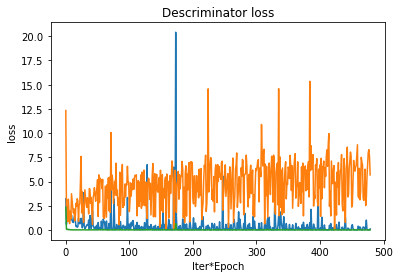

In [24]:
plt.figure()
plt.title("Descriminator loss")
plt.ylabel("loss")
plt.xlabel("Iter*Epoch")
plt.plot(D_losses)
plt.plot(G_losses)
plt.plot(Q_losses)
plt.show()

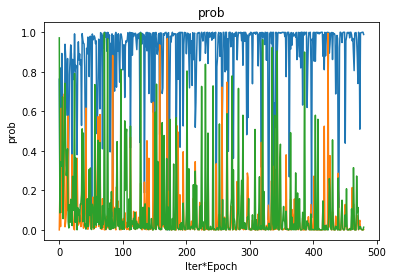

In [25]:
plt.figure()
plt.title("prob")
plt.ylabel("prob")
plt.xlabel("Iter*Epoch")
plt.plot(probs_real)
plt.plot(probs_fake_bG)
plt.plot(probs_fake_aG)
plt.show()

In [26]:
# saving models
torch.save(G.state_dict(), G_)

In [29]:
# test model
G = _netG(True).to(device)
G.load_state_dict(torch.load(G_))

z = torch.cat([fix_noise, one_hot], 1).view(-1, 64, 1, 1)
x_save = G(z)
save_image(x_save.data, './tmp/test.png', nrow=10)